# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "novel taxa". Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy of "novel taxa" are different from those used for mock and simulated communities.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: assignment == L - 1 (e.g., a novel species is assigned the correct genus)
    * overclassification: assignment == L (e.g., correct genus but assigns to a near neighbor)
    * misclassification: incorrect assignment at L - 1 (e.g., wrong genus-level assignment)
    
Where ``L`` = taxonomic level being tested




## Functions

In [1]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation)
from tax_credit.eval_framework import (parameter_comparisons,
                                       method_by_dataset)
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis)

from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display
import pandas as pd

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")
analysis_name = "novel-taxa-simulations"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
if not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir, summary_fp)
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches. For novel taxa, this means a match at the last common ancestor (level-1)

**overclassification_ratio** = proportion of taxa that were assigned to correct lineage but to a deeper taxonomic level than expected, rather than to LCA. E.g., assignment to another species in the clade

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [5]:
color_pallette = dict(rdp="seagreen", sortmerna="gray", uclust="blue", blast="black")

y_vars = ["Precision", "Recall", "F-measure",
          "match_ratio", "overclassification_ratio", 
          "underclassification_ratio", "misclassification_ratio"]

## Plot per-level classification accuracy

For novel-taxa analysis, a separate classification is performed at each taxonomic level using different test (unique taxa at level L) and training sets (ref - test taxonomies). Hence, results at each level L represent independent tests, unlike for mock and simulated communities where each level represents the accuracy of each species-level classification trimmed to level L. For novel taxa, results at level L indicate the accuracy with with method M assigns the correct lineage to a "novel" taxon, which is unrepresented in the reference at level L, e.g., level 6 indicates the performance with which each classifier assigns the correct genus to each species. 

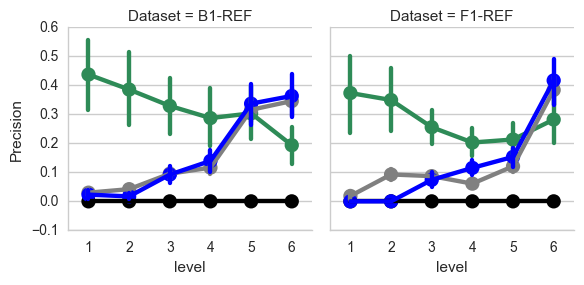

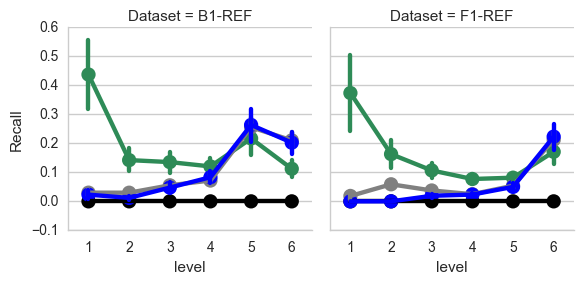

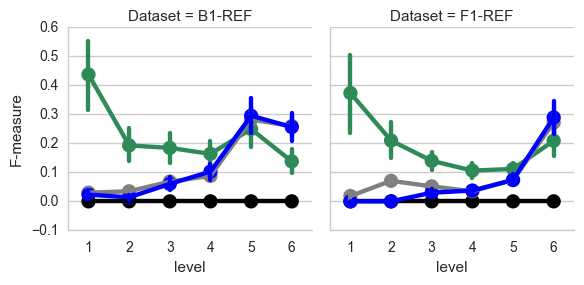

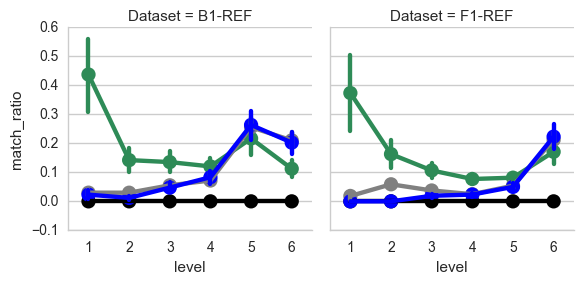

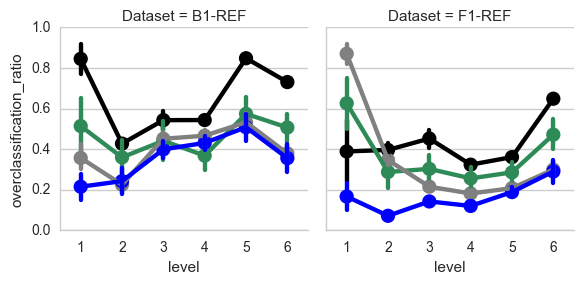

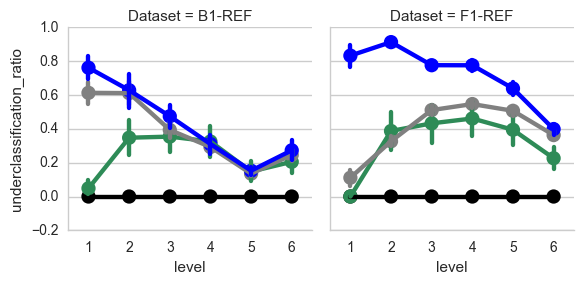

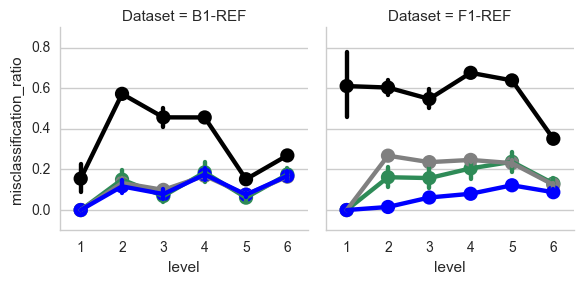

In [6]:
pointplot_from_data_frame(accuracy_results, "level", y_vars, 
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [46]:
result = per_level_kruskal_wallis(accuracy_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset                   Variable             1             2  \
0  B1-REF                match_ratio  2.506130e-11  1.156785e-10   
1  B1-REF   overclassification_ratio  3.846284e-08  1.299977e-03   
2  B1-REF  underclassification_ratio  3.509439e-22  4.277425e-10   
3  B1-REF    misclassification_ratio  6.902145e-28  2.826214e-08   
4  F1-REF                match_ratio  6.030257e-17  3.187258e-14   
5  F1-REF   overclassification_ratio  3.509439e-22  1.047154e-19   
6  F1-REF  underclassification_ratio  1.018890e-29  1.449745e-26   
7  F1-REF    misclassification_ratio  1.139941e-42  6.902145e-28   

              3             4             5             6  
0  3.806352e-06  3.864368e-05  4.397382e-04  5.290995e-06  
1  2.399851e-02  5.184554e-03  1.050806e-03  6.993745e-06  
2  1.020049e-08  1.254554e-06  1.298921e-07  2.758438e-07  
3  4.113607e-08  3.199775e-07  2.890334e-07  2.899128e-03  
4  2.887654e-11  1.024613e-09  6.066581e-06  2.246877e-04  
5  1.876439e-09  7.668931e-10  1.399116e-05  2.501198e-06  
6  3.597345e-20  2.792570e-18  3.657012e-12  2.732064e-11  
7  3.418785e-24  1.081196e-23  8.730290e-17  8.827752e-11

## Heatmap of method accuracy by parameter

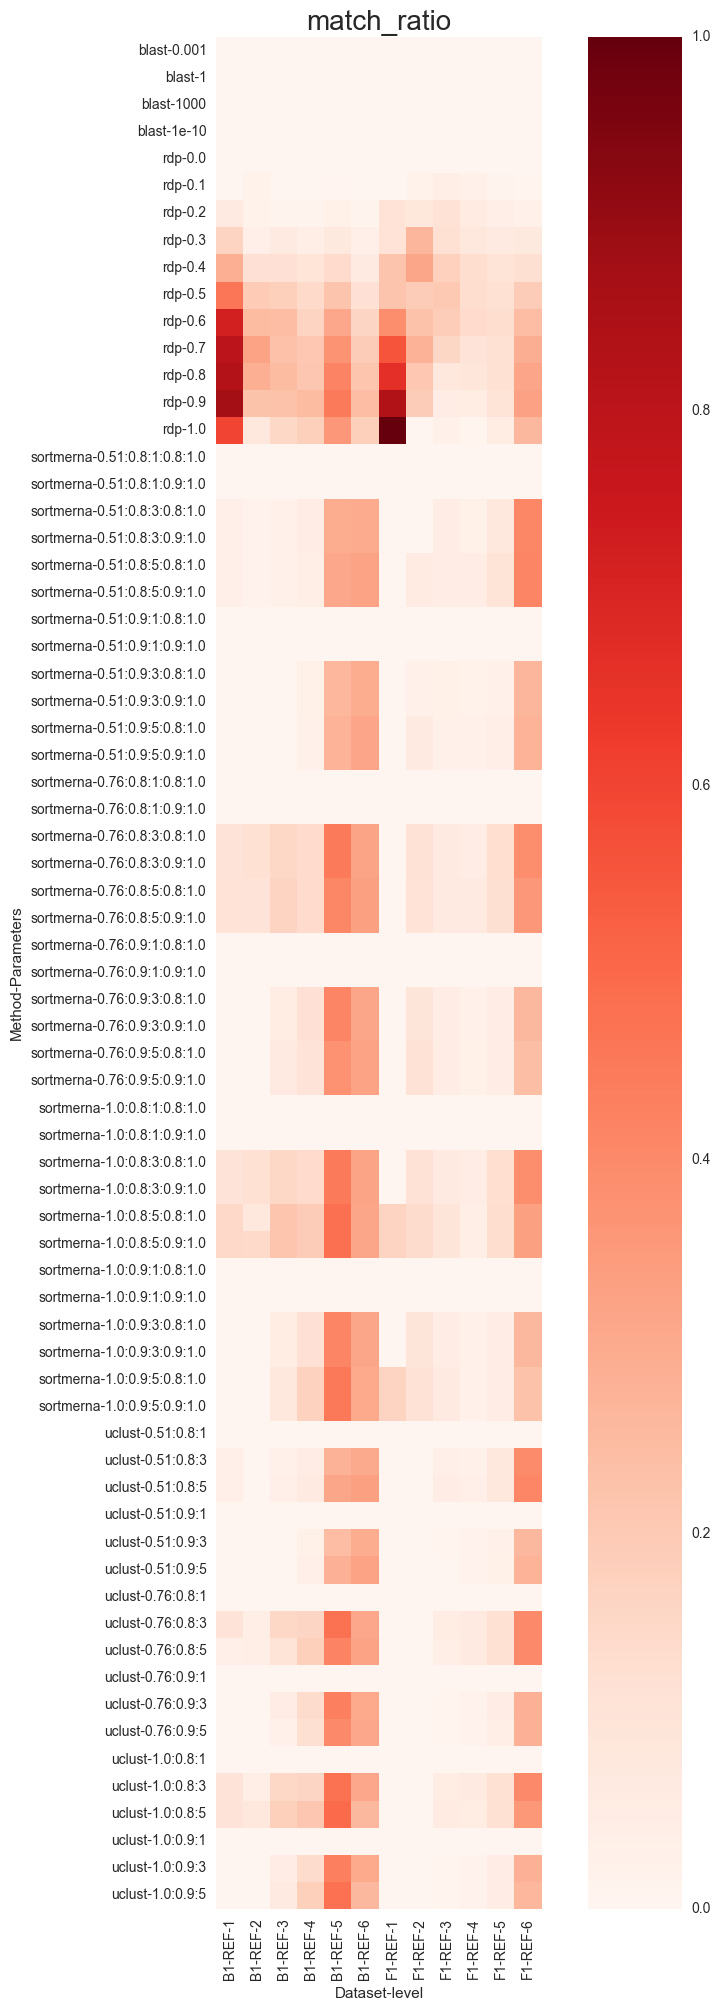

In [47]:
heatmap_from_data_frame(accuracy_results, metric="match_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

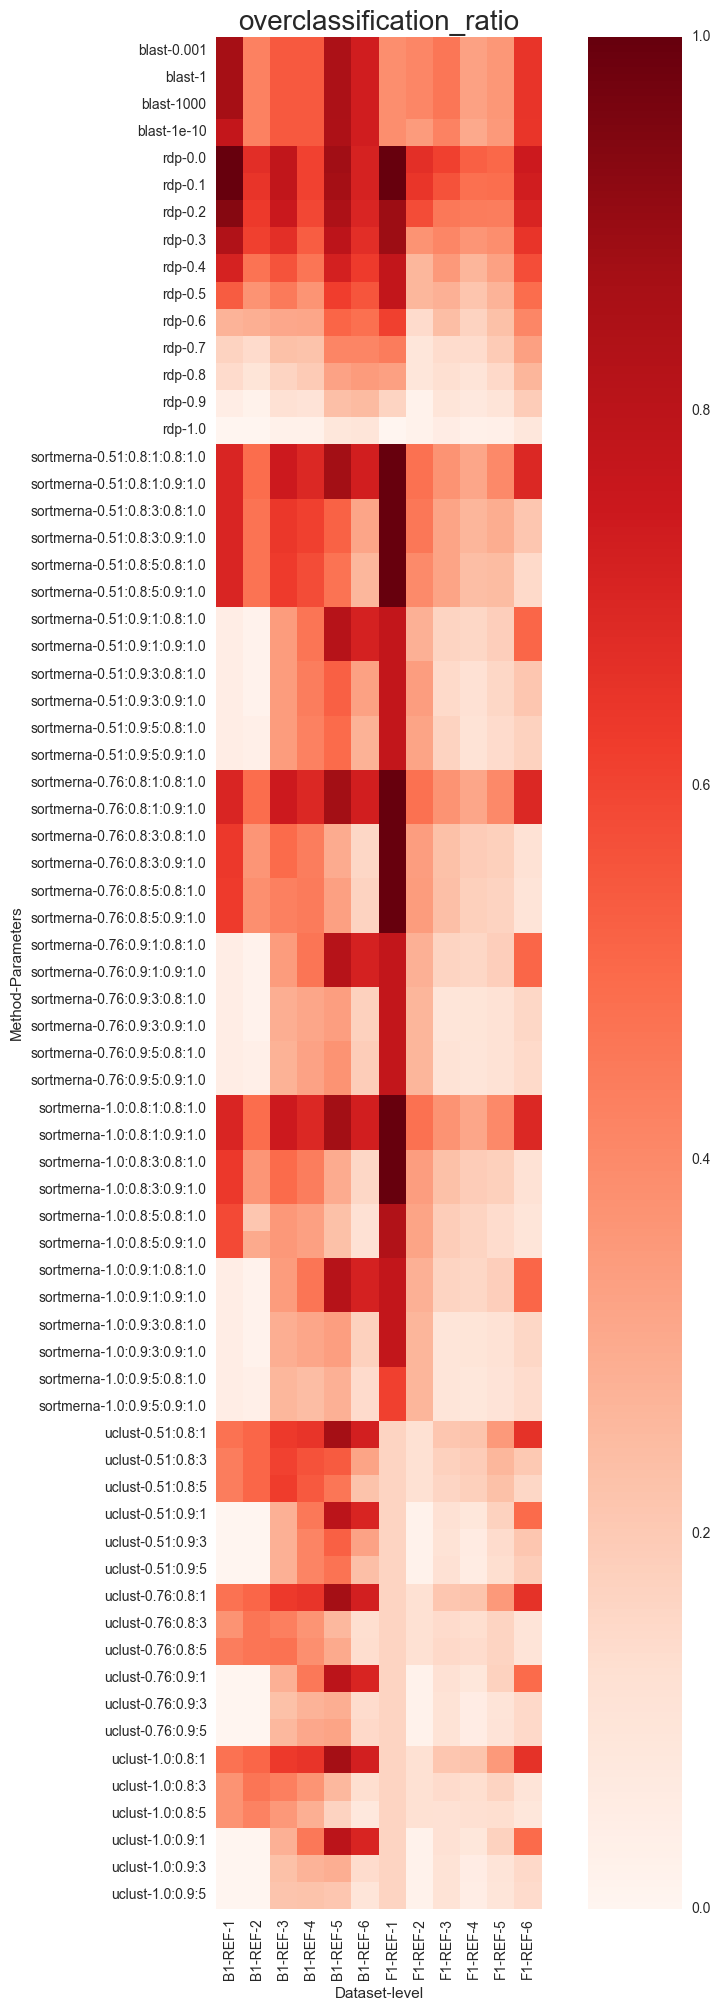

In [48]:
heatmap_from_data_frame(accuracy_results, metric="overclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

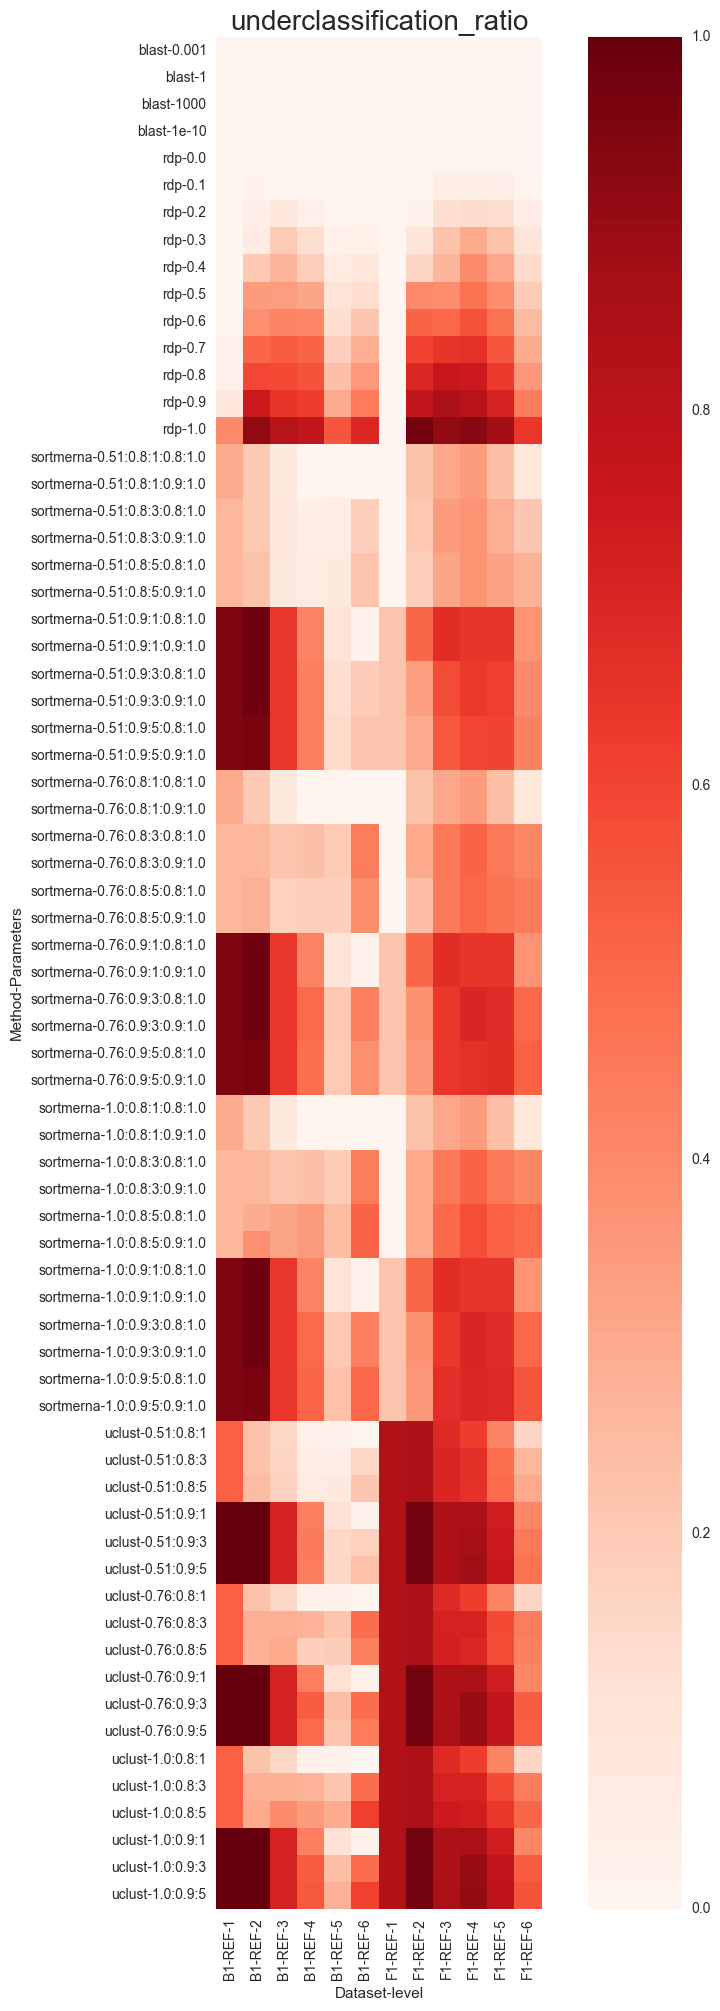

In [49]:
heatmap_from_data_frame(accuracy_results, metric="underclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

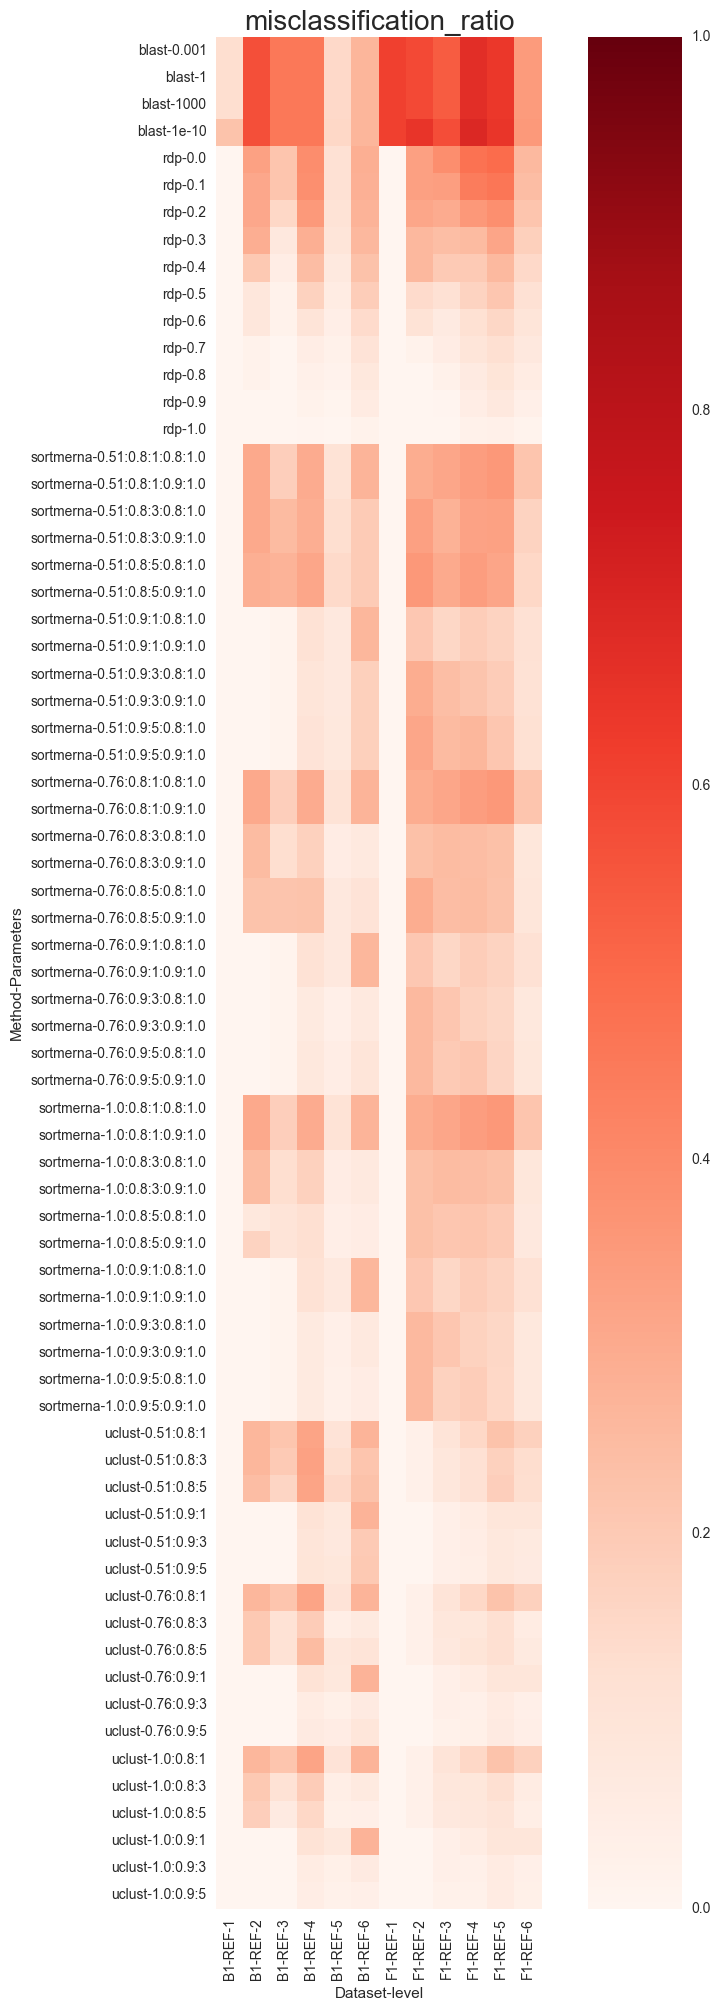

In [50]:
heatmap_from_data_frame(accuracy_results, metric="misclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* column indicates how many samples a given method achieved within one mean absolute deviation of the best result (which is why they sum to more than the total number of samples).

In [51]:
for method in accuracy_results['Method'].unique():
    top_params = parameter_comparisons(accuracy_results[accuracy_results["level"] == 6], 
                                       method, metrics=["match_ratio"], 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    print(method)
    display(top_params[:5])

blast


match_ratio
0.001            6
1                6
1000             6
1e-10            6

rdp


match_ratio
0.7            6
0.8            6
0.9            6
1.0            5
0.6            4

sortmerna


match_ratio
0.51:0.8:3:0.8:1.0            6
1.0:0.8:3:0.9:1.0             6
1.0:0.8:5:0.8:1.0             6
1.0:0.8:5:0.9:1.0             6
0.51:0.8:3:0.9:1.0            6

uclust


match_ratio
0.51:0.8:3            6
0.51:0.8:5            6
0.51:0.9:5            6
0.76:0.8:3            6
0.76:0.8:5            6

Now we rank the top-performing method/parameter combination for each method from family to species level

In [52]:
for dataset in accuracy_results['Dataset'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(accuracy_results[accuracy_results["level"] == level],
                                        dataset=dataset, sort_field='match_ratio', 
                                        display_fields=("Method", "Parameters", "match_ratio",
                                                       "misclassification_ratio",
                                                       "overclassification_ratio",
                                                       "underclassification_ratio"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

B1-REF level 4


Method         Parameters  match_ratio  misclassification_ratio  \
773        rdp                1.0     0.268657                 0.000000   
827     uclust          1.0:0.9:5     0.238806                 0.044776   
802  sortmerna  1.0:0.8:5:0.8:1.0     0.223881                 0.089552   
621      blast              0.001     0.000000                 0.492063   

     overclassification_ratio  underclassification_ratio  
773                  0.029851                   0.701493  
827                  0.238806                   0.477612  
802                  0.358209                   0.328358  
621                  0.507937                   0.000000

B1-REF level 5


Method         Parameters  match_ratio  misclassification_ratio  \
893     uclust          1.0:0.8:5     0.512088                 0.028571   
940  sortmerna  1.0:0.8:5:0.8:1.0     0.487414                 0.045767   
841        rdp                0.9     0.472527                 0.010989   
828      blast              0.001     0.000000                 0.160440   

     overclassification_ratio  underclassification_ratio  
893                  0.160440                   0.298901  
940                  0.247140                   0.219680  
841                  0.226374                   0.290110  
828                  0.839560                   0.000000

B1-REF level 6


Method          Parameters  match_ratio  misclassification_ratio  \
1087     uclust          0.51:0.8:3     0.355301                 0.217765   
1205  sortmerna  0.76:0.8:5:0.9:1.0     0.343662                 0.111268   
1186        rdp                 0.9     0.252113                 0.054930   
1035      blast               0.001     0.000000                 0.246418   

      overclassification_ratio  underclassification_ratio  
1087                  0.282235                   0.144699  
1205                  0.176056                   0.369014  
1186                  0.246479                   0.446479  
1035                  0.753582                   0.000000

F1-REF level 4


Method          Parameters  match_ratio  misclassification_ratio  \
1942        rdp                 0.6     0.190476                 0.161905   
1963  sortmerna  0.76:0.8:5:0.8:1.0     0.085714                 0.257143   
1990     uclust          0.76:0.8:3     0.085714                 0.152381   
1863      blast               0.001     0.000000                 0.691589   

      overclassification_ratio  underclassification_ratio  
1942                  0.152381                   0.495238  
1963                  0.180952                   0.476190  
1990                  0.123810                   0.638095  
1863                  0.308411                   0.000000

F1-REF level 5


Method          Parameters  match_ratio  misclassification_ratio  \
2100  sortmerna  0.76:0.8:3:0.9:1.0     0.155789                 0.256842   
2149        rdp                 0.6     0.144068                 0.175847   
2266     uclust          0.76:0.8:3     0.135729                 0.107784   
2070      blast               0.001     0.000000                 0.644211   

      overclassification_ratio  underclassification_ratio  
2100                  0.151579                   0.435789  
2149                  0.224576                   0.455508  
2266                  0.157685                   0.598802  
2070                  0.355789                   0.000000

F1-REF level 6


Method          Parameters  match_ratio  misclassification_ratio  \
2434  sortmerna  0.51:0.8:5:0.8:1.0     0.425448                 0.162556   
2399     uclust          0.51:0.8:5     0.415454                 0.123180   
2359        rdp                 0.9     0.335386                 0.033035   
2277      blast               0.001     0.000000                 0.356436   

      overclassification_ratio  underclassification_ratio  
2434                  0.140135                   0.271861  
2399                  0.157335                   0.304031  
2359                  0.186450                   0.445129  
2277                  0.643564                   0.000000